 Colab use relavtive path, *“Data/train/image\1487.tif”* will cause error

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: typing-extensions, gast, astunparse, flatbuffers, numpy, keras-preprocessing, protobuf, setuptools, absl-py, tensorboard, opt-einsum, six, libclang, tf-estimator-nightly, termcolor, google-pasta, h5py, grpcio, keras, wrapt, tensorflow-io-gcs-filesystem
Required-by: kapre


In [1]:
!/opt/bin/nvidia-smi

Mon Apr 18 12:05:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath('__file__')))

from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import datetime
import xlwt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#  walk in the file_path
%cd '/content/drive/My Drive/ComputerVision'

/content/drive/My Drive/ComputerVision


In [6]:
from seg_unet import unet
from dataProcess import trainGenerator, color_dict

In [7]:
'''
Dataset paths
'''

#  Note: // and \

train_image_path = "Data/train/image"
train_label_path = "Data/train/label"
validation_image_path = "Data/validation/image"
validation_label_path = "Data/validation/label"

In [8]:
'''
Model parameters
'''

batch_size = 6

classNum = 13  # classNum includes background

input_size = (512, 512, 3)

epochs = 50

learning_rate = 1e-4  # Initial learning_rate

premodel_path = None  # Pre-training model path

model_path = "Model/0418_unet_model.hdf5"  # Model saving path

In [9]:
'''
Model parameters
'''

#  Number of training/validation data
train_num = len(os.listdir(train_image_path))
validation_num = len(os.listdir(validation_image_path))

#  How many batch_size per epoch in training/validation data
steps_per_epoch = train_num / batch_size
validation_steps = validation_num / batch_size

#  Color dictionary of labels, for one-hot coding
colorDict_RGB, colorDict_GRAY = color_dict(train_label_path, classNum)

In [10]:
#  Generate training/validation dataset at the rate of batch_size
train_Generator = trainGenerator(batch_size,
                                 train_image_path, 
                                 train_label_path,
                                 classNum ,
                                 colorDict_GRAY,
                                 input_size)

validation_data = trainGenerator(batch_size,
                                 validation_image_path,
                                 validation_label_path,
                                 classNum,
                                 colorDict_GRAY,
                                 input_size)


#  Define model
model = unet(pretrained_weights = premodel_path, 
             input_size = input_size, 
             classNum = classNum, 
             learning_rate = learning_rate)

#  Print model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 up_sampling2d_2 (UpSampling2D)  (None, 256, 256, 25  0          ['batch_normalization_13[0][0]'] 
                                6)                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 12  131200      ['up_sampling2d_2[0][0]']        
                                8)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 25  0           ['batch_normalization_3[0][0]',  
                                6)                                'conv2d_16[0][0]']              
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 12  295040      ['concatenate_2[0][0]']          
          

In [12]:
#  Callback functions
#  Stop training if val_loss does not decrease for 10 consecutive rounds
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

#  if 3 epochs pass without val_loss dropping, the learning rate will halve
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, verbose = 1)
model_checkpoint = ModelCheckpoint(model_path,
                                   monitor = 'loss',
                                   verbose = 1,  # Log display: 0->Slient mode, 1->Progress bar, 2->One line per round
                                   save_best_only = True)

In [13]:
#  Get current time
start_time = datetime.datetime.now()

In [14]:
'''
Model training
'''

history = model.fit(train_Generator,
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    callbacks = [early_stopping, model_checkpoint, model_checkpoint],
                    validation_data = validation_data,
                    validation_steps = validation_steps)

Epoch 1/50
382/381 [==============================] - ETA: -2s - loss: 2.5826 - accuracy: 0.1553
Epoch 1: loss improved from inf to 2.58257, saving model to Model/0418_unet_model.hdf5

Epoch 1: loss did not improve from 2.58257
381/381 [==============================] - 1157s 3s/step - loss: 2.5826 - accuracy: 0.1553 - val_loss: 2.5536 - val_accuracy: 0.1952
Epoch 2/50
382/381 [==============================] - ETA: -1s - loss: 2.5449 - accuracy: 0.1849
Epoch 2: loss improved from 2.58257 to 2.54493, saving model to Model/0418_unet_model.hdf5

Epoch 2: loss did not improve from 2.54493
381/381 [==============================] - 610s 2s/step - loss: 2.5449 - accuracy: 0.1849 - val_loss: 2.5378 - val_accuracy: 0.2024
Epoch 3/50
382/381 [==============================] - ETA: 0s - loss: 2.5314 - accuracy: 0.1898
Epoch 3: loss improved from 2.54493 to 2.53143, saving model to Model/0418_unet_model.hdf5

Epoch 3: loss did not improve from 2.53143
381/381 [==============================] - 4

In [15]:
#  Total training time
end_time = datetime.datetime.now()
log_time = "训练总时间: " + str((end_time - start_time).seconds / 60) + "m"
time = datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d-%H%M%S')
print(log_time)
with open('TrainTime_%s.txt'%time,'w') as f:
    f.write(log_time)

训练总时间: 326.9166666666667m


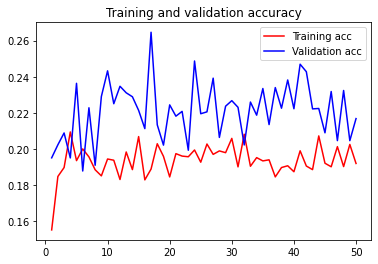

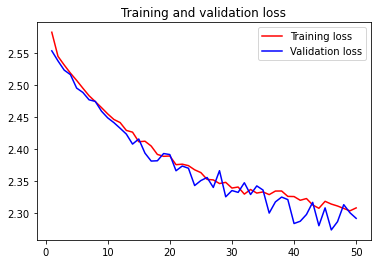

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
book = xlwt.Workbook(encoding='utf-8', style_compression=0)
sheet = book.add_sheet('test', cell_overwrite_ok=True)

for i in range(len(acc)):
    sheet.write(i, 0, acc[i])
    sheet.write(i, 1, val_acc[i])
    sheet.write(i, 2, loss[i])
    sheet.write(i, 3, val_loss[i])

book.save(r'AccAndLoss_%s.xls'%time)
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("accuracy_%s.png"%time, dpi = 300)
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("loss_%s.png"%time, dpi = 300)
plt.show()

In [20]:
from dataProcess import testGenerator, saveResult
import os

In [22]:
test_image_path = "Data/test/image"
test_label_path = "Data/test/label"

save_path = r"Predict"

test_num = len(os.listdir(test_image_path))

classNum = 13

input_size = (512, 512, 3)

output_size = (492, 492)

colorDict_RGB, colorDict_GRAY = color_dict(test_label_path, classNum)

model = unet(model_path)

testGene = testGenerator(test_image_path, input_size)

#  Numpy array of predicted values
results = model.predict_generator(testGene,
                                  test_num,
                                  verbose = 1)


saveResult(test_image_path, save_path, results, colorDict_GRAY, output_size)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


285/285 [==============================] - 15s 50ms/step
